# Multidimensional Pattern identification with SAX
## Building Benchmarking


This script performs pattern identification over the {time, site} cuboid, which shows an inter-building analytical frame, typically relevant for cross building benchmarking.

The data is first normalized then transformed using SAX over normalized daily sequences. Motifs are identified across buildings, and a final clustering phase is executed over the reduced counts of sequences. 

Results are presented visually allowing interpretable analytics.

In [1]:
# Import modules
import pandas as pd
import numpy as np
import time
from sklearn.cluster import KMeans
import sklearn.metrics as metrics
# SAX package - source https://github.com/seninp/saxpy
from saxpy.alphabet import cuts_for_asize
from saxpy.znorm import znorm
from saxpy.sax import ts_to_string
from saxpy.paa import paa
from sklearn.preprocessing import StandardScaler
# Plotting modules
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
plt.rcdefaults()
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.colors import n_colors
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

# Version
version = "v1.0"

# Path definition
path_data = "..\\data\\cube\\"
path_fig_out = "..\\figures\\building_bench\\"

## Read

In [2]:
def reduce_mem_usage(df, verbose=True):
    """"Function to reduce the memory usage of a dataframe.
    Source: https://www.kaggle.com/caesarlupum/ashrae-start-here-a-gentle-introduction"""

    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [23]:
# Read Cuboid
meter = "electricity"
df = pd.read_csv(path_data + "cuboid_A_"+meter+".csv", index_col="timestamp")
df.dropna(axis=1, how='all', inplace=True)

# Format index to datetime object
df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S')

# Reduce memory usage
df = reduce_mem_usage(df, verbose=True)
df.head()

Mem. usage decreased to 52.17 Mb (75.0% reduction)


,Bear_assembly_Angel,Bear_assembly_Beatrice,Bear_assembly_Danial,Bear_assembly_Diana,Bear_assembly_Genia,Bear_assembly_Harry,Bear_assembly_Jose,Bear_assembly_Roxy,Bear_assembly_Ruby,Bear_education_Alfredo,...,Wolf_office_Emanuel,Wolf_office_Haydee,Wolf_office_Joana,Wolf_office_Nadia,Wolf_office_Rochelle,Wolf_public_Norma,Wolf_retail_Harriett,Wolf_retail_Marcella,Wolf_retail_Toshia,Wolf_science_Alfreda
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,225.750,9.562500,NaN,NaN,183.125,NaN,149.75,9.8125,51.6250,0.100647,...,13.492188,5.363281,14.796875,50.250,8.843750,71.6875,22.093750,9.640625,17.937500,87.2500
2016-01-01 01:00:00,225.750,9.562500,NaN,NaN,183.125,NaN,149.75,9.8125,51.6250,0.100647,...,13.492188,5.363281,14.796875,50.250,8.843750,71.6875,22.093750,9.640625,17.937500,87.2500
2016-01-01 02:00:00,225.750,9.562500,NaN,NaN,183.125,NaN,149.75,9.8125,51.6250,0.100647,...,13.492188,5.363281,14.796875,50.250,8.843750,71.6875,22.093750,9.640625,17.937500,87.2500
2016-01-01 03:00:00,222.375,9.812500,NaN,NaN,185.250,NaN,152.25,9.8750,51.6250,0.104370,...,13.460938,5.886719,14.960938,50.250,8.742188,71.2500,21.828125,9.539062,17.875000,87.0000
2016-01-01 04:00:00,227.375,9.546875,NaN,NaN,185.500,NaN,151.25,9.9375,51.3125,0.106262,...,13.398438,5.835938,15.031250,50.125,8.679688,71.6875,21.687500,9.492188,17.609375,86.9375


## Pre-Mining transformation functions

In [4]:
from sklearn.preprocessing import MinMaxScaler
def scale_NanRobust(data_array, scaler):
    """ A function to scale an array while being robust to outliers.
    Adapted from: https://stackoverflow.com/questions/55280054/handling-missing-nan-values-on-sklearn-preprocessing"""
    # Set valid mask
    nan_mask = np.isnan(data_array)
    valid_mask = ~nan_mask
    # create a result array
    result = np.full(data_array.shape, np.nan)
    # assign only valid cases to
    result[valid_mask] = scaler.fit_transform(data_array[valid_mask].reshape(-1, 1)).reshape(data_array[valid_mask].shape)
    return result

def scale_df_columns_NanRobust(df_in, target_columns, scaler=MinMaxScaler(feature_range=(1, 2))):
    """"A function to normalize columns of a dataframe per column, while being robust to Nan values.
    The function returns a similar dataframe with missing values in identical places - normalized with the scaler object."""
    # Identify target from non-target column values
    nontarget_columns = list(set(df_in.columns) - set(target_columns))
    df = df_in[target_columns].copy()
    # Scale over the target columns
    array_scaled = []
    for col in df.columns:
        array_scaled.append(scale_NanRobust(df[col].values, scaler))
    df_scaled = pd.DataFrame(np.vstack(array_scaled).transpose(), columns=df.columns)
    # Set scaled dataframe index
    df_scaled[df_in.index.name] = df_in.index
    df_scaled.set_index([df_in.index.name], inplace=True, drop=True)
    # Merge non-target columns to the scaled frame
    df_scaled[nontarget_columns] = df_in[nontarget_columns]
    return df_scaled

## SAX functions

In [5]:
def SAX_mining(df_in, W=4, A=3):
    """"Function to perform daily SAX mining on input dataframe"""
    # Input definition of the function
    df_sax = df_in.copy()
    df_sax['Day'] = df_sax.index.dayofyear
    df_sax['Hour'] = df_sax.index.hour

    # Daily SAX over the year with reduced daily size
    sax_dict, counts, sax_data = dict(), dict(), dict()
    for meter in df_in.columns.values:
        # Daily heatmaps over all year
        sax_data[meter] = pd.pivot_table(df_sax, values=meter,
                                  index=['Day'], columns='Hour')
        sax_data[meter] = reduce_mem_usage(sax_data[meter], verbose=False)

        # Daily SAX obtained here with hourly resolution
        daily_sax = []
        for i in range(sax_data[meter].shape[0]):
            dat_paa = paa(sax_data[meter].values[i], W)
            daily_sax.append(ts_to_string(dat_paa, cuts_for_asize(A)))
        sax_dict[meter] = daily_sax

        # Now count the number of similar elements in the SAX list
        counts[meter] = Counter(sax_dict[meter])
    return sax_dict, counts, sax_data

def sax_count_reformat(sax_dict):
    """"Function to format SAX counts to a unified dataframe."""
    df_concat = [] #pd.DataFrame(columns=df_cub2.columns)
    for meter_data in sax_dict:
        counts[meter_data] = Counter(sax_dict[meter_data])
        # Create a dataframe from the counter object
        df_concat.append(pd.DataFrame.from_dict(counts[meter_data], orient='index', columns=[meter_data]))
    # Now concatenate the dictionary to one dataframe
    df_count = pd.concat(df_concat, axis=1)  # Reformated dataframe
    return df_count

def SAXcount_hm_wdendro(df_count, title):
    # Create Side Dendrogram
    # source: https://plotly.com/python/dendrogram/
    dendo = ff.create_dendrogram(df_count.values, orientation='left', labels=list(df_count.index.values))
    for i in range(len(dendo['data'])):
        dendo['data'][i]['xaxis'] = 'x2'
    # Create Heatmap
    dendro_leaves_txt = dendo['layout']['yaxis']['ticktext']
    # Convert the txt leaves to integer index values
    dendro_leaves = []
    for txt in df_count.index.values:
        dendro_leaves.append(list(dendro_leaves_txt).index(txt))
    dendro_leaves = list(map(int, dendro_leaves))

    heat_data = df_count.values[dendro_leaves, :]

    # Calling the subplots
    fig = go.Figure(data=go.Heatmap(z=heat_data,
                                    x=df_count.columns,
                                    y=df_count.index[dendro_leaves],
                                    # zmax=pzmax, zmin=pzmin,
                                    colorbar={"title": "Counts"},
                                    colorscale='Blues'))
    p_width = len(df_count.columns)*5 if len(df_count.columns)*5 > 400 else 400
    fig.update_layout(height=900, width=p_width,
                      xaxis={"tickmode": "array"},
                      title_text=f"SAX counts for attribute: {title}",
                      plot_bgcolor='#fff'
                      )
    fig.show()
    return fig

## Clustering & visualisation functions

In [6]:
def elbow_wcss(X, n_cluster_max):
    """"Within Cluster Sum of Squares (WCSS) method for optimal number of clusters identification"""
    wcss, sil = [], []  # Within Cluster Sum of Squares (WCSS) & silhouette index
    for i in range(2, n_cluster_max):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans_pred_y = kmeans.fit_predict(X)
        wcss.append(kmeans.inertia_)  # WCSS
        sil.append(metrics.silhouette_score(X, kmeans_pred_y, metric="euclidean"))  # Silhouette score
    return wcss, sil

def similarity_index_plot(wcss, sil):
    fig, axs = plt.subplots(2, 1, sharex=True)
    axs[0].scatter(range(2,len(sil)+2),sil,
                   c='c', marker='v')
    axs[1].scatter(range(2,len(wcss)+2),wcss,
                   c='r', marker='o')
    # Legend
    axs[0].set_ylabel('Silhouette')
    axs[1].set_ylabel('Cluster Sum of Squares')
    axs[1].set_xlabel('cluster number')
    # Set ticks inside
    plt.xticks(range(2,len(sil)+2), range(2,len(sil)+2))
    axs[0].tick_params(axis="y", direction="in", left="off", labelleft="on")
    axs[0].tick_params(axis="x", direction="in", left="off", labelleft="on")
    axs[1].tick_params(axis="x", direction="in", left="off", labelleft="on")
    axs[1].tick_params(axis="y", direction="in", left="off", labelleft="on")
    axs[0].grid(axis='y', color='grey', linestyle='--', linewidth=0.5, alpha=0.4)
    axs[1].grid(axis='y', color='grey', linestyle='--', linewidth=0.5, alpha=0.4)
    fig.tight_layout()
    plt.show()
    return fig

def cluster_counter_plot(counts, title=None):
    """Plot motif counts per cluster with whiskers"""
    stats = counts.describe()
    stats = stats.transpose().sort_values(by=['50%'], ascending=False).transpose()
    keys = counts.columns
    y_pos = np.arange(len(keys))
    yerr_pos = stats.loc['75%'].values - stats.loc['50%'].values
    yerr_neg = stats.loc['50%'].values - stats.loc['25%'].values
    # Plot
    fig = plt.figure(figsize=(6, 4))
    ax = plt.gca()
    plt.bar(y_pos,
             stats.loc['50%'].values,
             #yerr=stats.loc[['75%','25%']].values,          # Define error bar as the difference between 50% and quantiles
             yerr = [yerr_neg, yerr_pos],
             tick_label=keys,
             align='center',
             alpha=0.4)
    hfont = {'fontname': 'Times New Roman'}
    ax.tick_params(axis="y", direction="in", left="off", labelleft="on", labelsize=13)
    ax.tick_params(axis="x", direction="in", left="off", labelleft="on", labelsize=13)
    plt.xticks(y_pos, keys, rotation=90, **hfont)
    plt.yticks(**hfont)
    #plt.xlabel('Symbolic Aggregate Approximation sequences', **hfont)
    plt.ylabel('counts', fontsize=15, **hfont)
    plt.title(title, **hfont)
    plt.tight_layout()
    plt.show()
    return fig

# Motifs identification

In [24]:
# SAX Parameters
day_number_of_pieces = 4
alphabet_size = 3
scaler_function = StandardScaler()

# Normalize per attribute robust to Nans
df_normalized = scale_df_columns_NanRobust(df, df.columns, scaler=scaler_function)

# SAX transformation
sax_dict, counts, sax_data = SAX_mining(df_normalized, W=day_number_of_pieces, A=alphabet_size)

In [25]:
# Identifying sequence counts per building
df_count = sax_count_reformat(sax_dict)
df_count.fillna(0, inplace=True)

# Plotting per building sequence counts as heatmap
fig = SAXcount_hm_wdendro(df_count, meter)
fig.write_image(path_fig_out+"SAXcounts_"+meter+"_"+version+".png")

## Cross-building clustering
We proceed to perform cross-site clustering based on motif similarities between them.

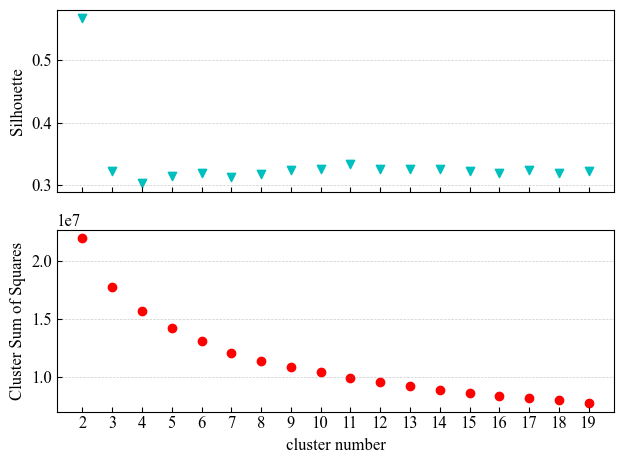

In [27]:
## Clustering identified motifs

# Filter discords from established threshold
motif_threshold_number = 5
df_count_motifs = df_count[df_count > motif_threshold_number]
df_count_motifs.fillna(0, inplace=True)

# Identify optimal cluster number
wcss, sil = elbow_wcss(df_count_motifs.transpose(), n_cluster_max=20)

# Plots
plt.rcParams.update({'font.size': 12})
plt.rcParams['font.sans-serif'] = ['Times New Roman']
fig = similarity_index_plot(wcss, sil)
fig.savefig(path_fig_out+"CrossBlg_"+meter+"_cluster_SimilarityIndex_"+version+".jpg", dpi=300, bbox_inches='tight')

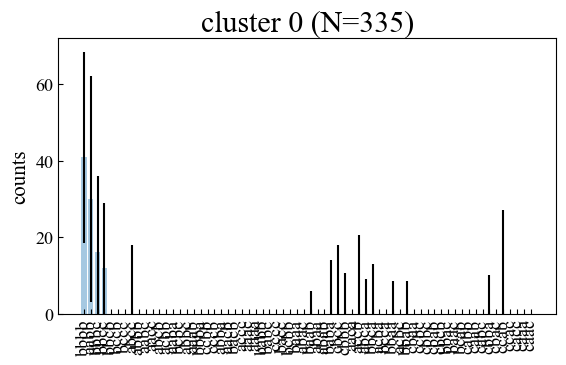

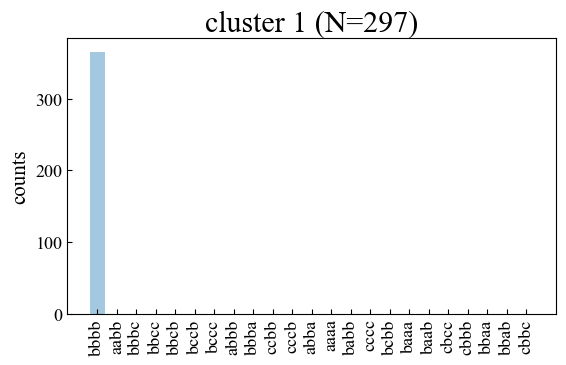

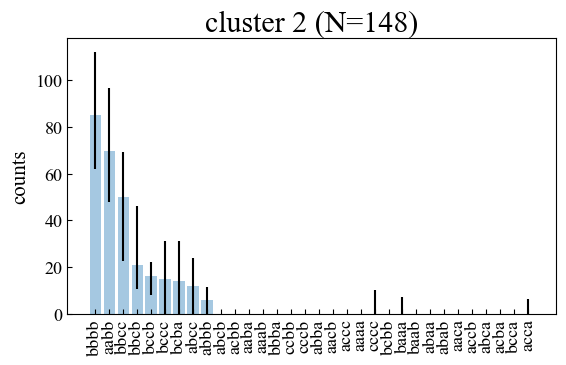

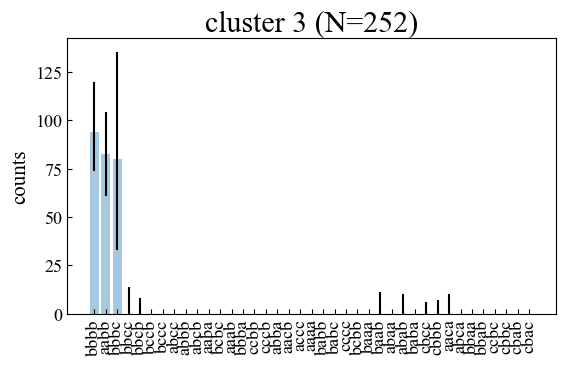

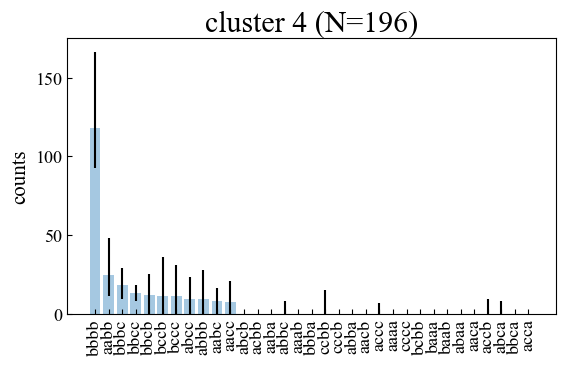

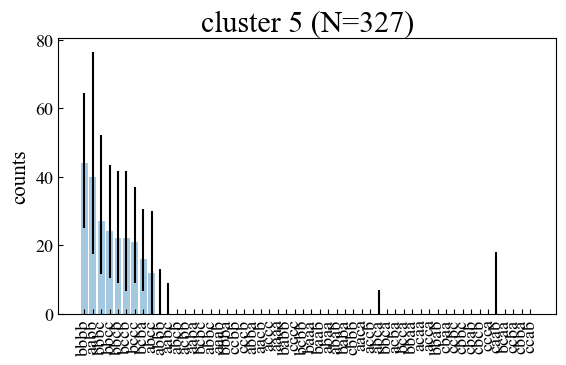

In [28]:
# Cluster identified motifs
nb_clusters_opt = 6
kmeans = KMeans(n_clusters=nb_clusters_opt, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans_pred_y = kmeans.fit_predict(df_count_motifs.transpose())

# Identify buildings & motifs per cluster
blg_clus, motifs, count_clustmotifs = dict(), dict(), dict()
for clus in range(nb_clusters_opt):
    # Identifying buildings within the cluster
    blg_clus[clus] = df_count_motifs.transpose()[kmeans_pred_y == clus].index.values
    # Extracting motifs within the cluster without empty columns (only zeros)
    dfc = df_count_motifs[blg_clus[clus]].replace(0, np.nan)
    dfc = dfc.dropna(how='all', axis=0)
    dfc = dfc.replace(np.nan, 0)
    motifs[clus] = dfc.index.values
    # Extracting motifs counts within cluster
    count_clustmotifs[clus] = df_count_motifs[blg_clus[clus]].transpose()[motifs[clus]]

# Plot counts per cluster as bar plots with whisker margins
plt.rcParams.update({'font.size': 18})
for clus in count_clustmotifs:
    fig = cluster_counter_plot(count_clustmotifs[clus], title="cluster " + str(clus) +" (N="+str(len(blg_clus[clus]))+")")
    fig.savefig(path_fig_out+"SAXclust_"+meter+"_clust_"+str(clus)+"_"+version+".jpg", dpi=300, bbox_inches='tight')